In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob as gb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE = (64,64)
BATCH_SIZE = 16
CHANNELS = 3
EPOCHES= 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/corn-or-maize-leaf-disease-dataset/data",
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [4]:
path ="/kaggle/input/corn-or-maize-leaf-disease-dataset/data"
size=[]
for folder in os.listdir(path):
    files = gb.glob(pathname=str(path+"//"+folder+"/*.jpg"))
    for file in files:
        image=plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)      1323
(768, 1024, 3)        8
(1200, 675, 3)        7
(2448, 3264, 3)       7
(900, 1200, 3)        5
                   ... 
(1024, 650, 3)        1
(640, 360, 3)         1
(371, 788, 3)         1
(200, 250, 3)         1
(378, 420, 3)         1
Length: 265, dtype: int64

In [5]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [6]:
len(dataset)

262

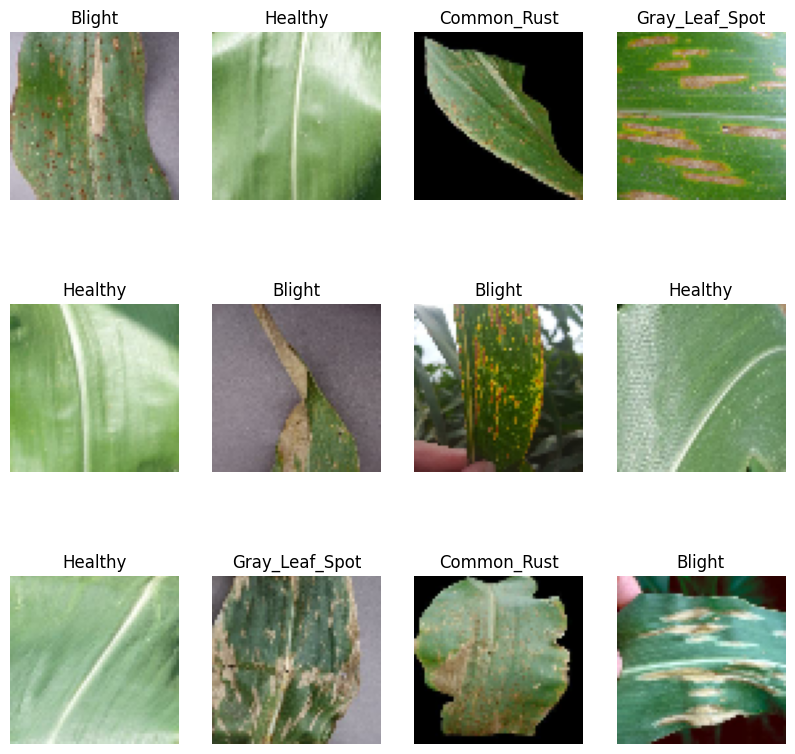

In [7]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [10]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 209

Length of Validation Dataset is 26

Length of Testing Dataset is 27


In [11]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(64,64),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
n_classes = 4
BATCH_SIZE=16
input_shape = (BATCH_SIZE,64,64,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(10,(3,3),activation ='relu',input_shape = input_shape),
    layers.MaxPooling2D(10,(2,2)),
    layers.Conv2D(20,kernel_size = (3,3),activation ='relu'),
    layers.MaxPooling2D(20,(2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)


In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 64, 64, 3)           0         
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 10)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 20)        1820      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 20)         0         
 2D)                                                  

In [15]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [69]:
history = model.fit(
train_ds,
epochs=5
    ,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/5
209/209 [==============================] - 19s 59ms/step - loss: 0.0524 - accuracy: 0.9829 - val_loss: 0.2350 - val_accuracy: 0.9351
Epoch 2/5
209/209 [==============================] - 19s 62ms/step - loss: 0.0417 - accuracy: 0.9835 - val_loss: 0.2046 - val_accuracy: 0.9543
Epoch 3/5
209/209 [==============================] - 19s 62ms/step - loss: 0.0879 - accuracy: 0.9704 - val_loss: 0.1738 - val_accuracy: 0.9519
Epoch 4/5
209/209 [==============================] - 19s 63ms/step - loss: 0.0555 - accuracy: 0.9793 - val_loss: 0.2359 - val_accuracy: 0.9519
Epoch 5/5
209/209 [==============================] - 23s 79ms/step - loss: 0.0385 - accuracy: 0.9868 - val_loss: 0.1941 - val_accuracy: 0.9351


In [70]:
scores = model.evaluate(test_ds)

27/27 [==============================] - 6s 3ms/step - loss: 0.1846 - accuracy: 0.9537


In [65]:
history

In [66]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 209}

In [67]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

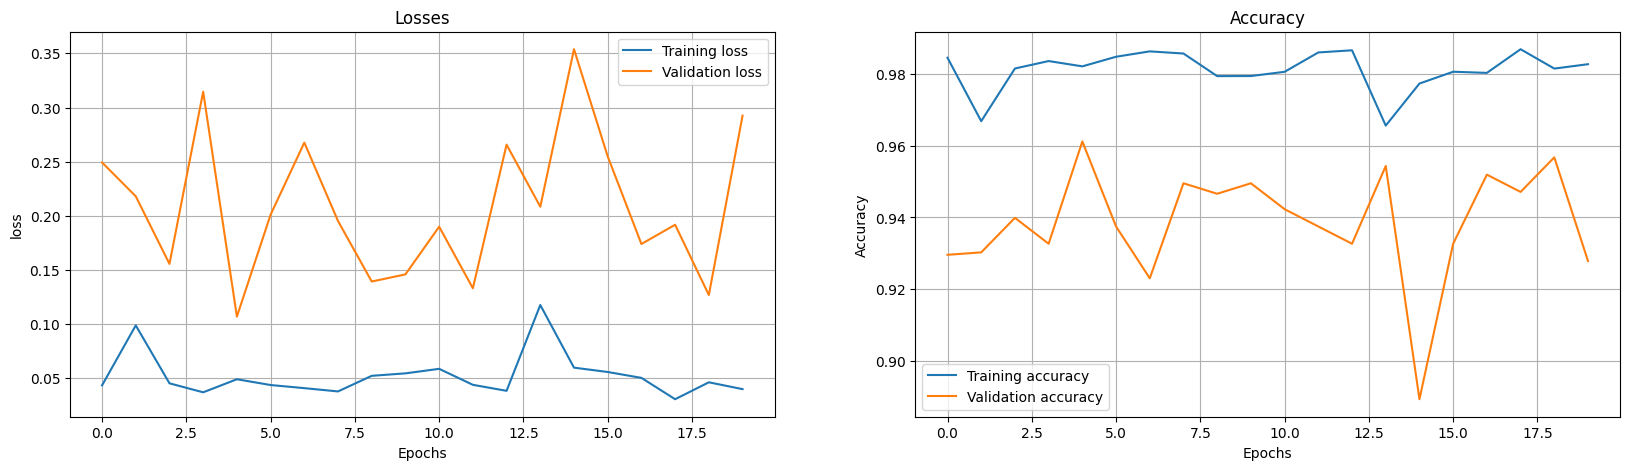

In [68]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

First Image to Predict :

Actual label: Common_Rust
1/1 [==============================] - 0s 22ms/step

Predicted label Common_Rust


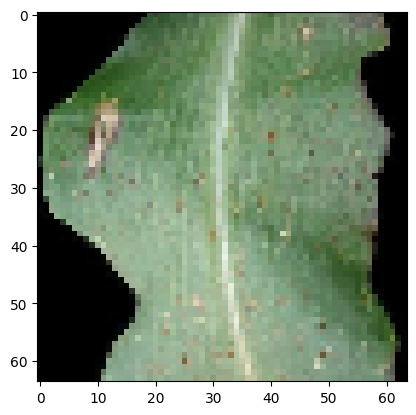

In [102]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model. predict (images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [103]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


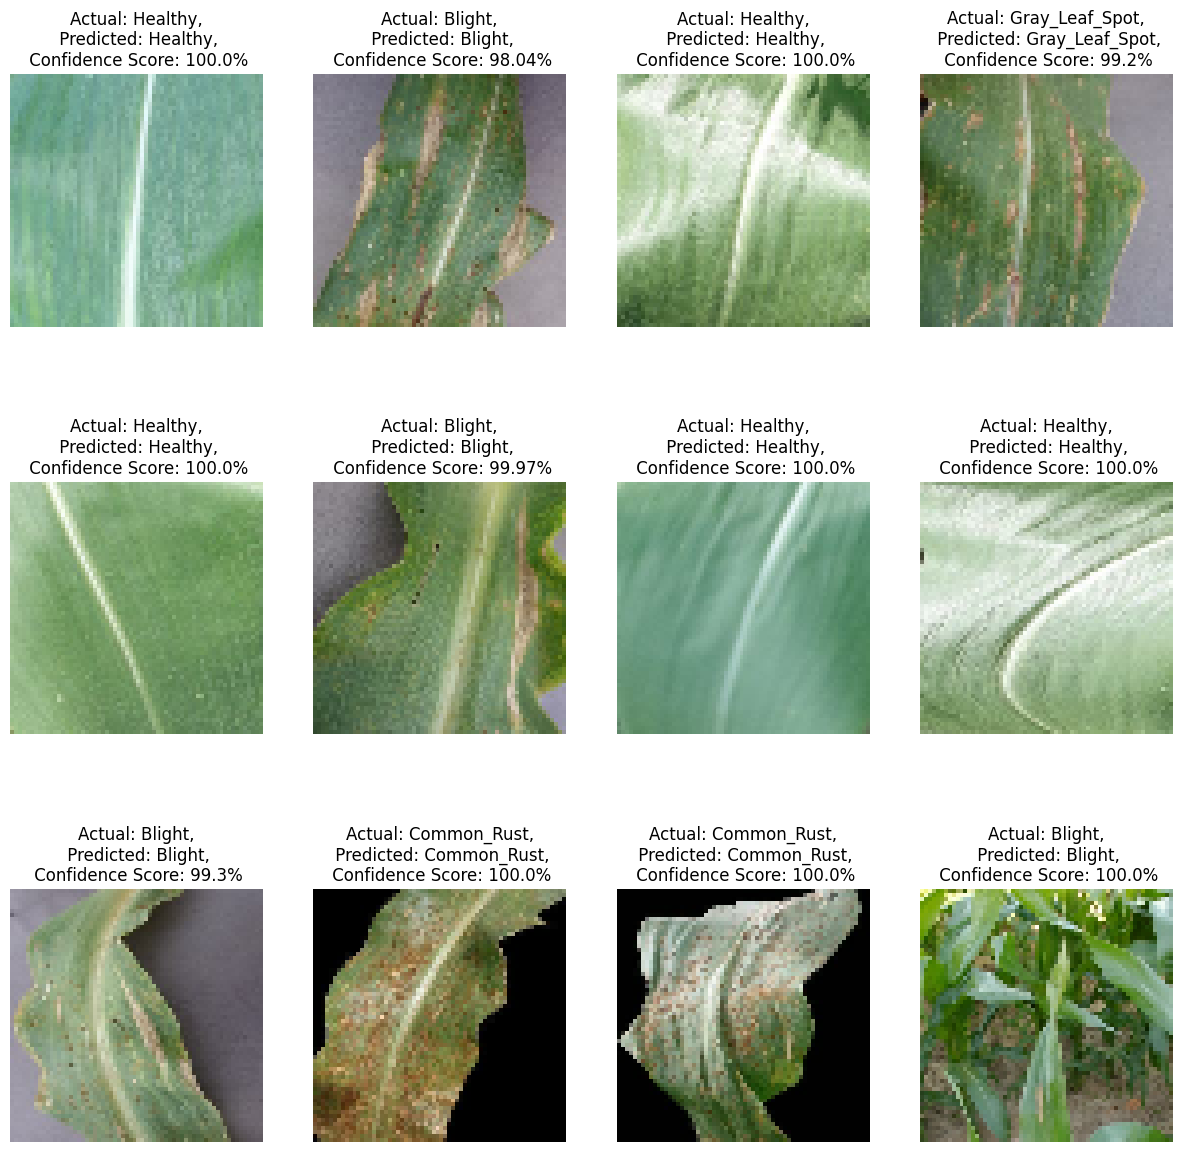

In [107]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [108]:
# model_version = 4
model.save('/kaggle/working/  paper111')